### This notebook shows an end to end example of a segmentation task
---

The sample data that we will be using is from the [Airbus Ship Detection](https://www.kaggle.com/c/airbus-ship-detection) competition from Kaggle

[1. Run length decoding of the input files to generate the masks](#step1)

[2. Saving the masks to disk](#step2)

[3. Setting up the data to be fed into our model with DataBunch](#step3)

[4. Initializing a UNet with a pretrained encoder, and training with recorder callback](#step4)

[5. Converting the masks generated by the model into run length encodings](#step5)

#### First some setup code

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")
from pathlib import Path

import cv2
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

#### 1. Run length decoding of the input files to generate the masks <a id='step1'/>

In [2]:
from utils.image import rle_encode, rle_decode

##### Before we read from the input file, first lets see how it works with a toy example

In [3]:
img = np.array([[0,0,0,1],
                [0,0,1,1],
                [1,0,0,0],
                [1,1,0,0]])

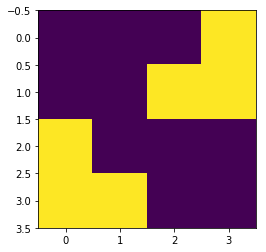

In [4]:
plt.imshow(img)

In [5]:
rle = rle_encode(img)

In [6]:
rle

'3 2 8 1 10 1 13 2'

In [7]:
decode = rle_decode(rle, shape=(4, 4))

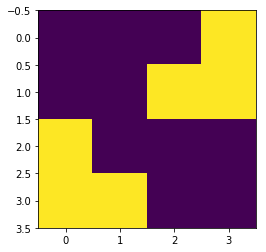

In [8]:
plt.imshow(decode)

##### Now load the RLE from our csv file with Pandas

In [9]:
ROOT_DATA_PATH = Path("data/segmentation")
IMAGE_DATA_PATH = ROOT_DATA_PATH / "images"
IMAGE_DATA_PATH.mkdir(parents=True, exist_ok=True)
MASK_DATA_PATH = ROOT_DATA_PATH / "masks"
MASK_DATA_PATH.mkdir(parents=True, exist_ok=True)
rle_df = pd.read_csv(ROOT_DATA_PATH / "airbus-segmentation-RLE.csv")

In [10]:
rle_df.head()

,ImageId,EncodedPixels
0,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
1,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
2,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
3,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
4,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...


##### Plot the results

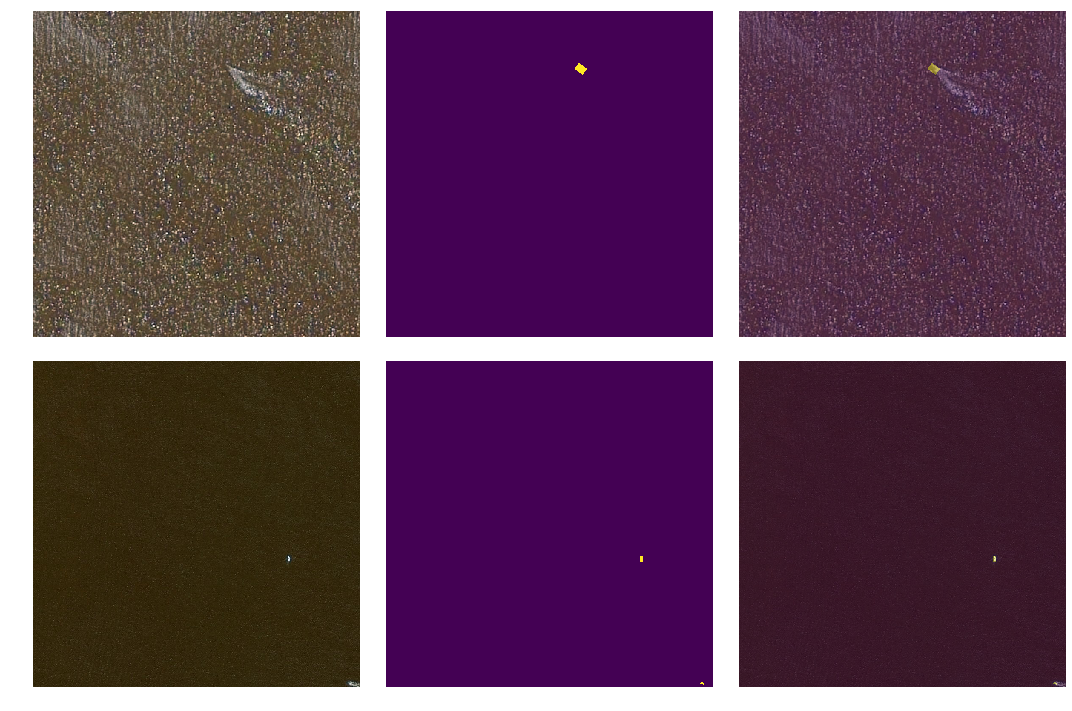

In [11]:
n_cols = 3
image_ids = rle_df['ImageId'].unique()[4:6]
fig, axs = plt.subplots(len(image_ids), n_cols, figsize=(15, 10))
axs = axs.flatten()
for i, image_id in enumerate(image_ids):
    img = cv2.imread(str(IMAGE_DATA_PATH / image_id))
    all_masks = np.zeros((768, 768))
    img_masks = rle_df.loc[rle_df['ImageId'] == image_id, 'EncodedPixels'].tolist()
    for mask in img_masks:
        all_masks += rle_decode(mask)
    axs[i * n_cols].axis('off')
    axs[i * n_cols + 1].axis('off')
    axs[i * n_cols + 2].axis('off')
    axs[i * n_cols].imshow(img)
    axs[i * n_cols + 1].imshow(all_masks)
    axs[i * n_cols + 2].imshow(img)
    axs[i * n_cols + 2].imshow(all_masks, alpha=0.4)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

---

#### 2. Saving the masks to disk <a id='step2'/>

##### Save the masks, we must use .png as .jpg is lossy and the masks won't be correctly generated

In [384]:
image_ids = rle_df['ImageId'].unique()
for i, image_id in enumerate(image_ids):
    img = cv2.imread(str(IMAGE_DATA_PATH / image_id))
    all_masks = np.zeros((768, 768))
    img_masks = rle_df.loc[rle_df['ImageId'] == image_id, 'EncodedPixels'].tolist()
    for mask in img_masks:
        all_masks += rle_decode(mask)
    save_path = str(MASK_DATA_PATH / Path(image_id).stem) + ".png"
    cv2.imwrite(save_path, all_masks)

---

#### 3. Setting up the data to be fed into our model with DataBunch with custom dataset <a id='step3'/>

In [13]:
from collections import namedtuple

import torch
import fastai

from fastai_extensions.basic_data import DataBunch
from utils.image import open_image, open_mask, image_net_normalize, image_net_denormalize, tensor2img

##### Define our own custom dataset to be used

In [14]:
class SegmentationDataset(torch.utils.data.Dataset):
    "A dataset for segmentation task."

    def __init__(self, x, y=None, tfms_info=None):
        if y is not None:
            assert len(x) == len(y)
            self.y = np.array(y)
        else:
            self.y = y
        self.x = np.array(x)
        self.tfms_info = tfms_info

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        ret = {}
        img = open_image(self.x[i], with_name=True)
        size = img.size if self.tfms_info.size is None else self.tfms_info.size
        ret['name'] = img.name
        if self.y is not None:
            mask = open_mask(self.y[i], with_name=True)
            ret['input'] = img.apply_tfms(tfms=self.tfms_info.tfms, size=size) if self.tfms_info else img
            ret['mask'] = mask.apply_tfms(tfms=self.tfms_info.tfms, size=size, do_resolve=False) if self.tfms_info else mask
            ret['input'] = ret['input'].data

            ret['mask'] = ret['mask'].data
        else:
            ret['input'] = img.apply_tfms(tfms=self.tfms_info.tfms, size=size) if self.tfms_info else img
            ret['input'] = ret['input'].data

        if self.tfms_info is not None and self.tfms_info.norm_fn:
            ret['input'] = self.tfms_info.norm_fn(ret['input'])
        return ret


def segmentation_collate_fn(batch):
    default_collate_batch = torch.utils.data.dataloader.default_collate(batch)
    x = default_collate_batch['input']
    y = {k: v for k, v in default_collate_batch.items() if k != 'input'}
    return x, y

##### Load in the images and the transformation to be used

In [15]:
image_paths = sorted([p for p in IMAGE_DATA_PATH.glob("*")], key=lambda p: p.stem)
mask_paths = sorted([p for p in MASK_DATA_PATH.glob("*")], key=lambda p: p.stem)
TransformInfo = namedtuple('TransformInfo', 'tfms size, norm_fn')
tfms = fastai.vision.get_transforms()

##### Now create our DataBunch

In [16]:
n_images = len(image_paths)
n_train_images = int(n_images * 0.8)

In [115]:
train_ds = SegmentationDataset(image_paths, mask_paths, tfms_info=TransformInfo(tfms=tfms[0], size=224, norm_fn=image_net_normalize))
val_ds = SegmentationDataset(image_paths, mask_paths, tfms_info=TransformInfo(tfms=tfms[1], size=224, norm_fn=image_net_normalize))
test_ds = SegmentationDataset(image_paths, tfms_info=TransformInfo(tfms=tfms[1], size=224, norm_fn=image_net_normalize))
data = DataBunch.create(train_ds, val_ds, test_ds, train_bs=8, val_bs=2, test_bs=2, collate_fn=segmentation_collate_fn)

# train_ds = SegmentationDataset(image_paths[:n_train_images], mask_paths[:n_train_images], tfms_info=TransformInfo(tfms=tfms[0], size=224, norm_fn=image_net_normalize))
# val_ds = SegmentationDataset(image_paths[n_train_images:], mask_paths[n_train_images:], tfms_info=TransformInfo(tfms=tfms[1], size=224, norm_fn=image_net_normalize))
# test_ds = SegmentationDataset(image_paths, tfms_info=TransformInfo(tfms=tfms[1], size=768, norm_fn=image_net_normalize))
# data = DataBunch.create(train_ds, val_ds, test_ds, train_bs=4, val_bs=2, test_bs=2, collate_fn=segmentation_collate_fn)

##### Plot the output

In [17]:
x, y = next(iter(data.train_dl))

In [18]:
inp  = tensor2img(x[0], denorm_fn=image_net_denormalize)
name = y['name'][0]
mask = tensor2img(y['mask'][0].squeeze())

Text(0.5, 1.0, '002c62c03.jpg')

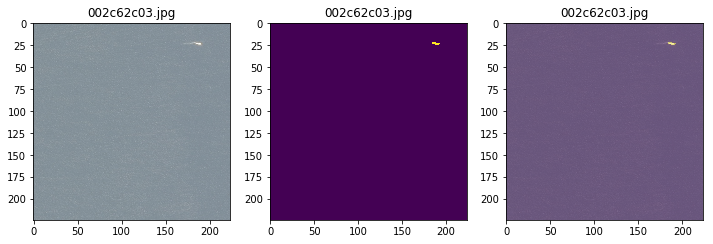

In [19]:
_, axs = plt.subplots(1, 3, figsize=(12, 12))
axs = axs.flatten()
axs[0].imshow(inp)
axs[0].set_title(name)
axs[1].imshow(mask)
axs[1].set_title(name)
axs[2].imshow(inp)
axs[2].imshow(mask, alpha=0.4)
axs[2].set_title(name)

---

#### 4. Initializing a UNet with a pretrained encoder, and training with recorder callback  <a id='step4'/>

In [383]:
import random
from collections import defaultdict, OrderedDict

import torch.nn.functional as F

from models.unet import dynamic_unet
from fastai_extensions.loss import LossWrapper, SoftDiceLoss, CELoss
from fastai_extensions.basic_train import Learner

##### Now we will define a callback to extract the mask from the data returned from the batch before feeding it into the network

In [21]:
class NameExtractionTrainer(fastai.Callback):
    def on_batch_begin(self, last_input, last_target, **kwargs):
        mask = last_target.get('mask')
        if mask is not None:
            return last_input, last_target['mask']
        else:
            return last_input, last_target

##### First we create a unet with a pretrained encoder and split the layers into layer groups for the trainer

In [22]:
encoder, unet = dynamic_unet(encoder="pytorch_resnet34", n_classes=2)
n_encoder_layers = len(list(fastai.flatten_model(encoder)))
layer_groups = fastai.split_model_idx(unet, [n_encoder_layers])
learn = Learner(data,
                layer_groups=layer_groups,
                model=unet,
                loss_func=LossWrapper([
                                      SoftDiceLoss(dice_loss_weights={
                                      "weight_for_class_0": 0.01,
                                      "weight_for_class_1": 0.1,
                                      }), 
                                      CELoss()
                                     ]),
                callbacks=[NameExtractionTrainer()])

##### Now we find the "optimal" training rate with the lr_find method, first we freeze the encoding layers, and find the LR for the decoding layers

In [23]:
# Uncomment this to see the layer_groups, there will be two groups one for the encoder and one for the decoder

# layer_groups

In [24]:
# Uncomment this to see which layers in the layer groups are currently being used for training

# learn.freeze_to(1)
# for lg in learn.layer_groups:
#     for l in lg:
#         print(l)
#         for p in l.parameters():
#             print(p.shape)
#             print(p.requires_grad)

In [25]:
import warnings
warnings.filterwarnings('ignore')
learn.lr_find(start_lr=[1e-5] * 2, end_lr=[100] * 2, num_it=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


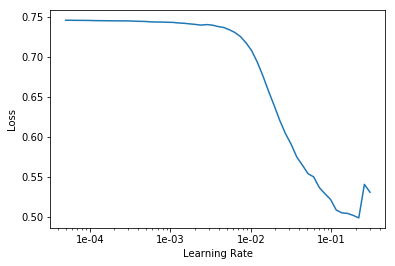

In [26]:
learn.recorder.plot()

It's hard to know the optimal learning rate due to the small amount of images but let's pick 5e-3 for the decoder, and 5e-6 for the encoder

##### Before we start the training define a output recorder callback class to record the results of our training

In [260]:
to_numpy = lambda t: t.cpu().data.numpy()

class OutputRecorder(fastai.Callback):
    _order = -10
    def __init__(self):
        self.inputs = defaultdict(list)
        self.names = defaultdict(list)
        self.targets = defaultdict(list)
        self.preds = defaultdict(list)
        self.preds_prob = defaultdict(list)
        self.phase = None
        
    def clear(self):
        self.inputs = defaultdict(list)
        self.names = defaultdict(list)
        self.targets = defaultdict(list)
        self.preds = defaultdict(list)
        self.preds_prob = defaultdict(list)
        
    def on_batch_begin(self, last_input, last_target, epoch, train, **kwargs):
        epoch = epoch + 1
        if train:
            self.phase = 'TRAIN'
        else:
            mask = last_target.get('mask')
            if mask is not None:
                self.phase = 'VAL'
            else:
                self.phase = 'TEST'
                
        inputs = tensor2img(last_input, denorm_fn=image_net_denormalize)
        self.inputs[(self.phase, epoch)].extend(inputs)
        self.names[(self.phase, epoch)].extend(last_target['name'])
        if self.phase == 'TRAIN' or self.phase == 'VAL':
            self.targets[(self.phase, epoch)].extend(to_numpy(last_target['mask']).squeeze())

    def on_loss_begin(self, last_output, epoch, train, **kwargs):
        epoch = epoch + 1
        self.preds[(self.phase, epoch)].extend(to_numpy(torch.argmax(last_output, dim=1)))
        self.preds_prob[(self.phase, epoch)].extend(to_numpy(F.softmax(last_output, dim=1)))
    
    def results_from_epoch(self, epoch, phase='VAL'):
        assert epoch != 0
        sorted_idx = np.argsort(self.names[(phase, epoch)])           
        ret = OrderedDict()
        ret = {"inputs": np.array(self.inputs[(phase, epoch)])[sorted_idx],
               "names" : np.array(self.names[(phase, epoch)])[sorted_idx],
               "predictions" : np.array(self.preds[(phase, epoch)])[sorted_idx],
               "probability_maps" : np.array(self.preds_prob[(phase, epoch)])[sorted_idx]}
        if self.phase == 'TRAIN' or self.phase == 'VAL':
            ret['targets'] = np.array(self.targets[(phase, epoch)])[sorted_idx]
        return ret

##### Now we train, but we will do a tiny hack by setting the model to train mode, since the training images are quite different, batch norm will cause NaNs during evaluation, but setting the model to train model we will alleviate this

In [261]:
class SetModelTrainModeHack(fastai.LearnerCallback):
    _order=-20                                     
    def __init__(self, learn:Learner):             
        super().__init__(learn)                    
        self.model = self.learn.model                  
        
    def on_batch_begin(self, **kwargs):
        self.model.train()

##### Now we can train the model w/ differentiae learning rate

In [258]:
encoder, unet = dynamic_unet(encoder="pytorch_resnet34", n_classes=2)
n_encoder_layers = len(list(fastai.flatten_model(encoder)))
layer_groups = fastai.split_model_idx(unet, [n_encoder_layers])
learn = Learner(data,
                layer_groups=layer_groups,
                model=unet,
                loss_func=LossWrapper([
                                      SoftDiceLoss(dice_loss_weights={
                                      "weight_for_class_0": 1,
                                      "weight_for_class_1": 1,
                                      }), 
                                      CELoss()
                                     ]),
                callbacks=[NameExtractionTrainer()],
                callback_fns=[SetModelTrainModeHack])

train_output_recorder = OutputRecorder()
learn.fit(epochs=30, lr=[5e-5, 5e-3], callbacks=[train_output_recorder])

Total time: 02:43
epoch  train_loss  valid_loss
1      1.332905    1.277248    (00:05)
2      1.230324    0.969131    (00:05)
3      1.058226    0.599302    (00:05)
4      0.897465    0.425600    (00:05)
5      0.767445    0.360701    (00:05)
6      0.671243    0.357127    (00:05)
7      0.601216    0.351851    (00:05)
8      0.558602    0.430537    (00:05)
9      0.523254    0.397648    (00:05)
10     0.485612    0.361885    (00:05)
11     0.456889    0.336433    (00:05)
12     0.427633    0.349535    (00:05)
13     0.415649    0.323960    (00:05)
14     0.396404    0.296311    (00:05)
15     0.380627    0.309606    (00:05)
16     0.365648    0.284470    (00:05)
17     0.350131    0.291975    (00:05)
18     0.342143    0.281395    (00:06)
19     0.335573    0.323695    (00:05)
20     0.331704    0.278767    (00:05)
21     0.328231    0.264944    (00:05)
22     0.324506    0.272396    (00:05)
23     0.314571    0.292407    (00:05)
24     0.309548    0.302512    (00:05)
25     0.308000 

##### See the results of the segmentation, we can plot by how the output of the model has changed for each epoch

In [277]:
result_dict = defaultdict(list)
epochs_to_plot = [1, 5, 10, 20, 30]

In [278]:
for epoch in epochs_to_plot:
    for i, (inp, name, pred, prob, tar) in enumerate(zip(*train_output_recorder.results_from_epoch(epoch=epoch, phase='VAL').values())):
        result_dict[name].append((inp, name, pred, prob, tar))

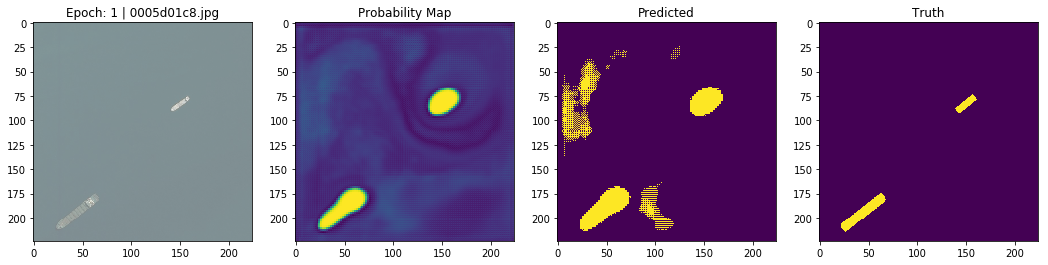

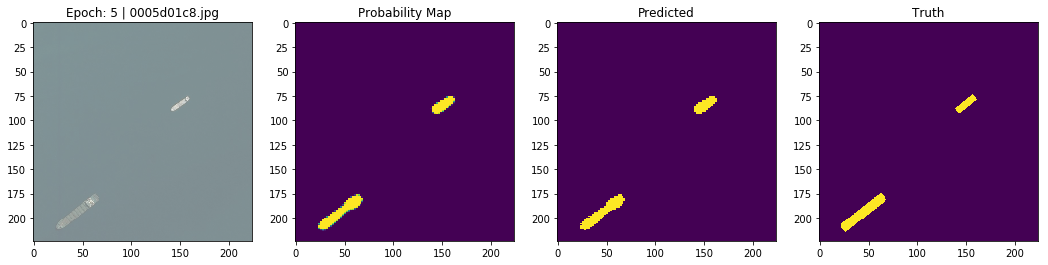

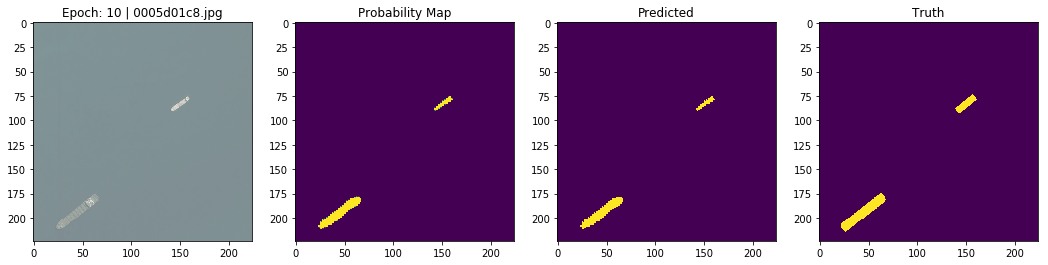

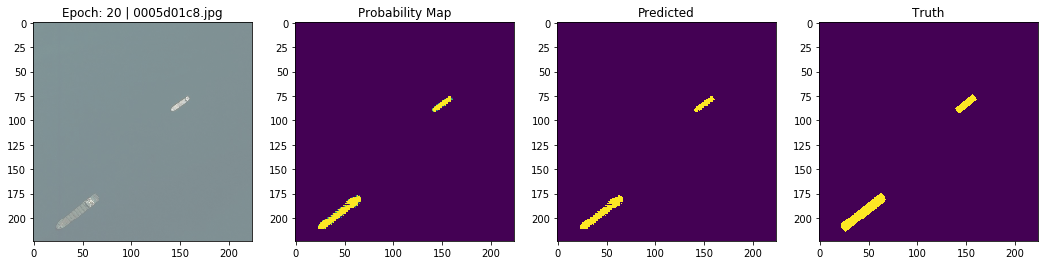

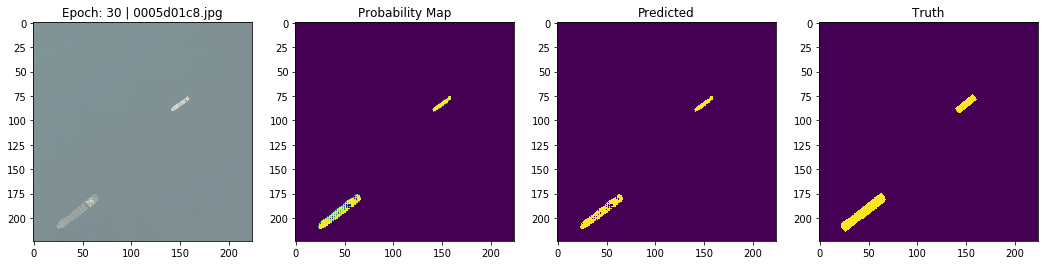

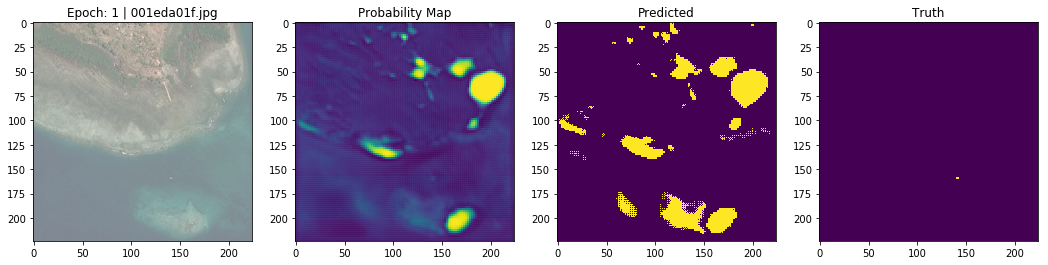

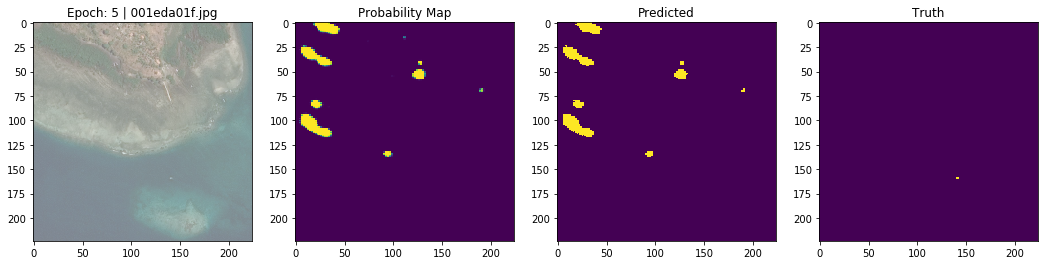

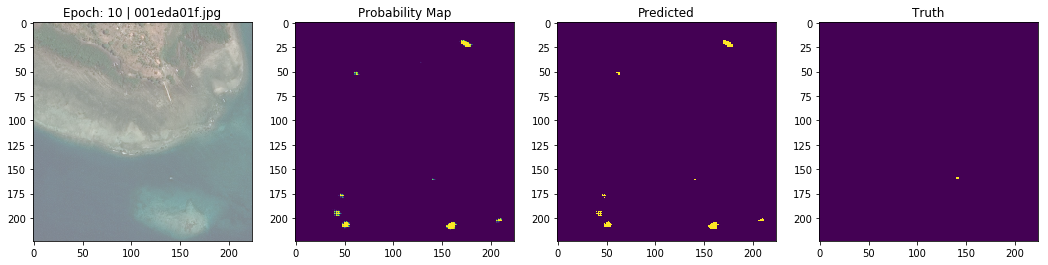

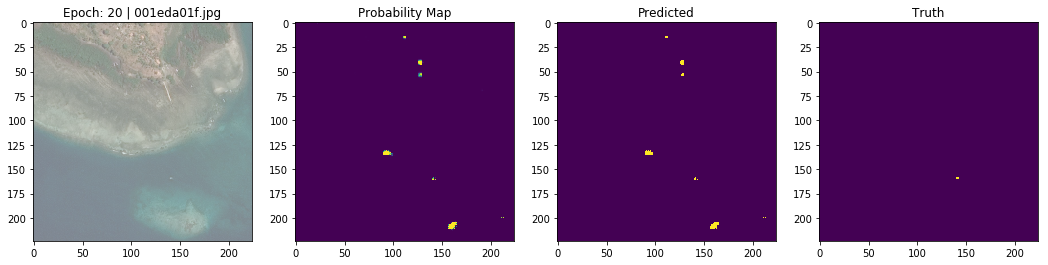

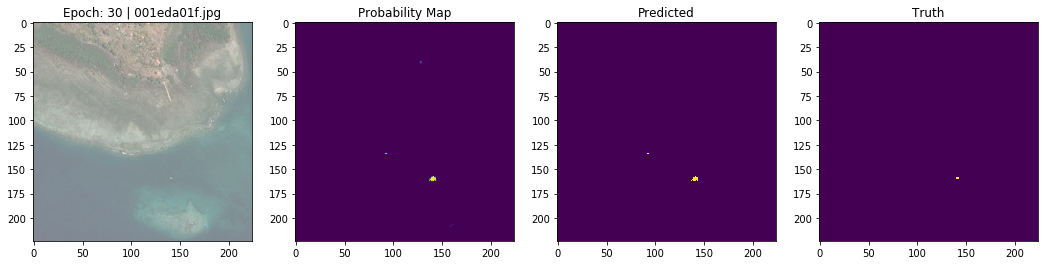

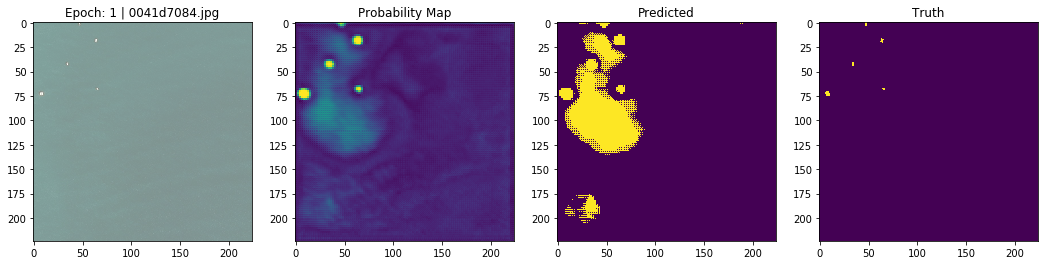

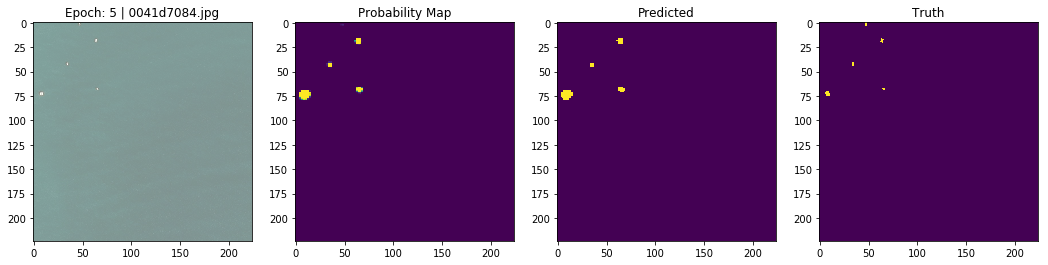

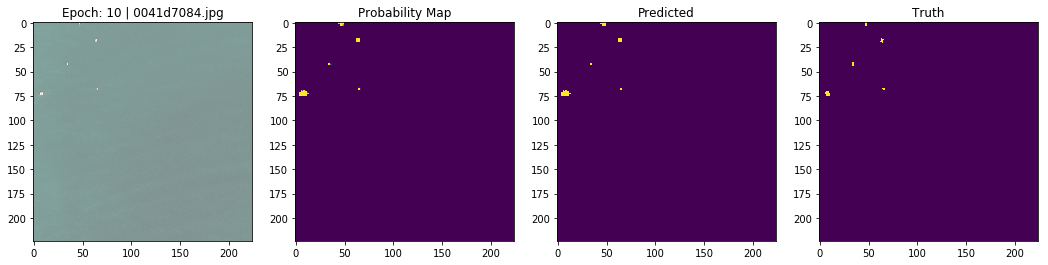

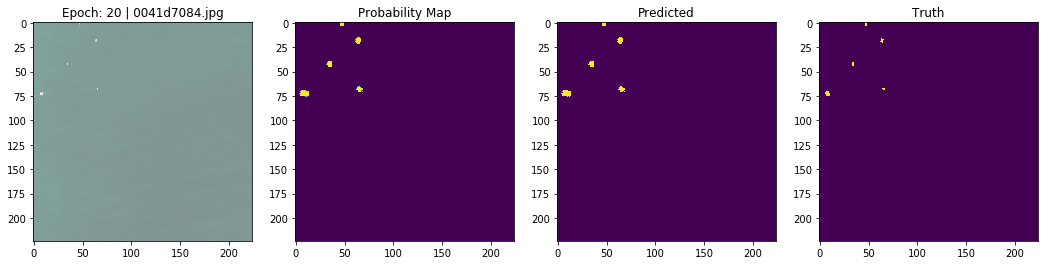

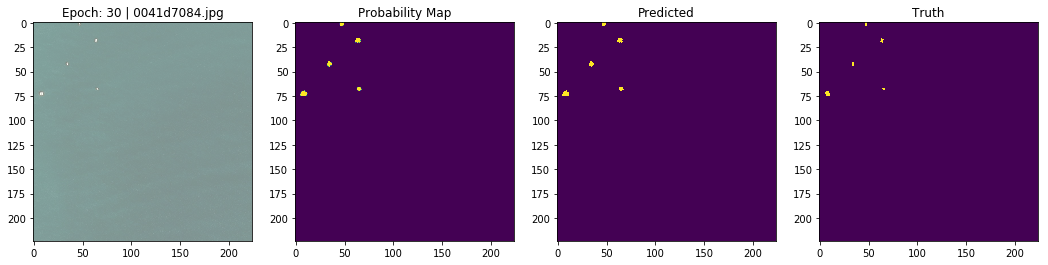

In [279]:
n_to_plot = 3
keys_to_use = list(result_dict.keys())
random.shuffle(keys_to_use)
keys_to_use = keys_to_use[:n_to_plot]
for name in keys_to_use:
    for epoch, (inp, name, pred, prob, tar) in zip(epochs_to_plot, result_dict[name]):
        _, axs = plt.subplots(1, 4, figsize=(18, 18))
        axs[0].imshow(inp)
        axs[0].set_title(f"Epoch: {epoch} | {name}")
        axs[1].imshow(prob[1,...])
        axs[1].set_title('Probability Map')
        axs[2].imshow(pred)
        axs[2].set_title('Predicted')
        axs[3].imshow(tar)
        axs[3].set_title('Truth')
        plt.show()

##### Or choose an epoch to plot 

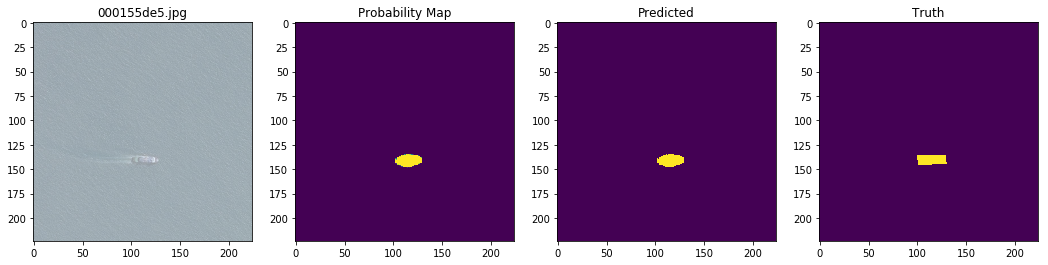

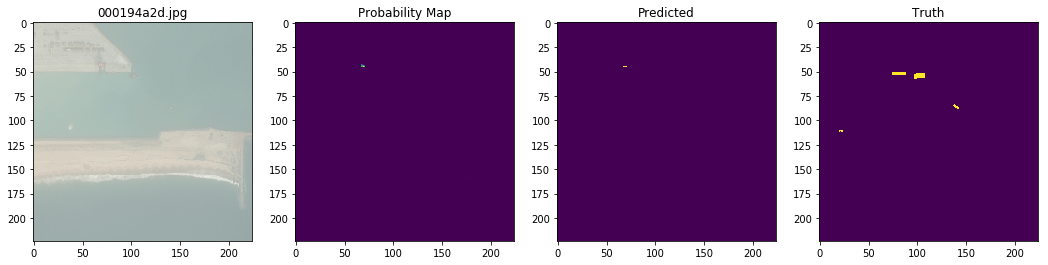

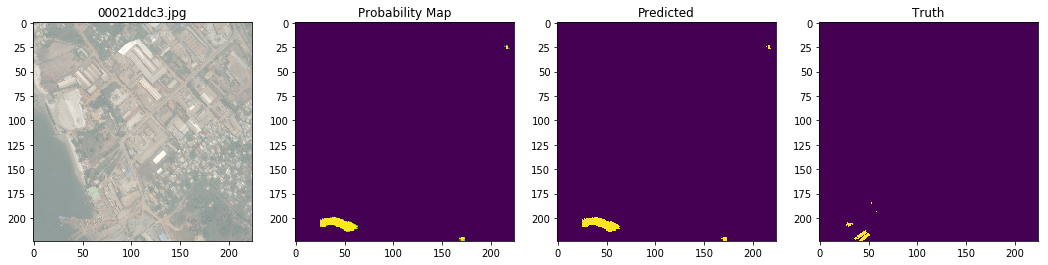

In [281]:
for i, (inp, name, pred, prob, tar) in enumerate(zip(*train_output_recorder.results_from_epoch(epoch=10, phase='VAL').values())):
    if i == n_to_plot:
        break
    _, axs = plt.subplots(1, 4, figsize=(18, 18))
    axs[0].imshow(inp)
    axs[0].set_title(name)
    axs[1].imshow(prob[1,...])
    axs[1].set_title('Probability Map')
    axs[2].imshow(pred)
    axs[2].set_title('Predicted')
    axs[3].imshow(tar)
    axs[3].set_title('Truth')
    plt.show()

---

#### 5. Converting the masks generated by the model into run length encodings <a id='step5'/>

##### First we define a callback to record the RLEs

In [376]:
class RLERecorder(fastai.Callback):
    _order = -10
    def __init__(self):
        self.inputs = []
        self.names = []
        self.masks =[]
        self.rles = []
    
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        inputs = tensor2img(last_input, denorm_fn=image_net_denormalize)
        self.inputs.extend(inputs)
        self.names.extend(last_target['name'])
            
    def on_loss_begin(self, last_output, **kwargs):
        predictions = to_numpy(torch.argmax(last_output, dim=1).squeeze())
        rles = [rle_encode(pred) for pred in predictions]
        self.masks.extend(predictions)
        self.rles.extend(rles)

##### Now predict on the test set and see the results

In [377]:
rle_recorder = RLERecorder()
output_recorder = OutputRecorder()
learn.predict_on_test_dl(callbacks=[rle_recorder, output_recorder])

##### Plot the results from the output recorder

In [378]:
name = output_recorder.results_from_epoch(epoch=1, phase='TEST')['names'][30]
inp =  output_recorder.results_from_epoch(epoch=1, phase='TEST')['inputs'][30]
prediction = output_recorder.results_from_epoch(epoch=1, phase='TEST')['predictions'][30]

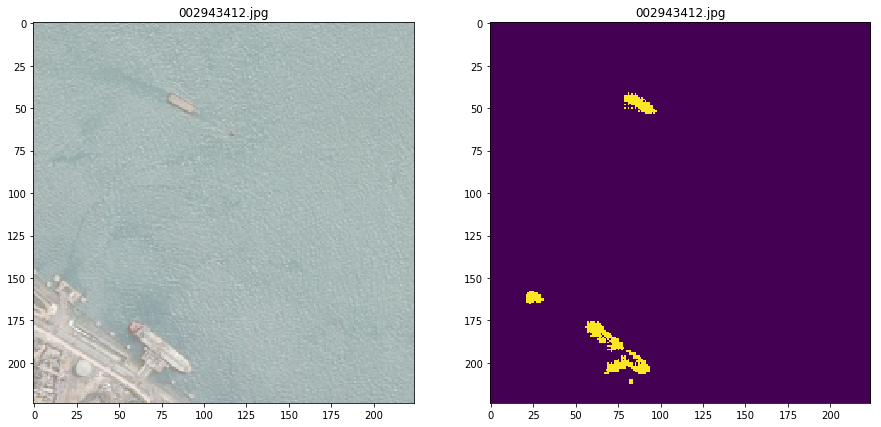

In [379]:
_, axs = plt.subplots(1, 2, figsize=(15, 15))
axs = axs.flatten()
axs[0].set_title(name)
axs[0].imshow(inp)
axs[1].set_title(name)
axs[1].imshow(prediction)

##### Plot the results from the RLE recorder

In [380]:
sorted_idx = np.argsort(rle_recorder.names)
sorted_names = np.array(rle_recorder.names)[sorted_idx]
sorted_inputs = np.array(rle_recorder.inputs)[sorted_idx]
sorted_masks = np.array(rle_recorder.masks)[sorted_idx]
sorted_rles = np.array(rle_recorder.rles)[sorted_idx]
name = sorted_names[30]
inp = sorted_inputs[30]
mask = sorted_masks[30]
rle = sorted_rles[30]
rle_decoded = rle_decode(rle, shape=(224, 224))

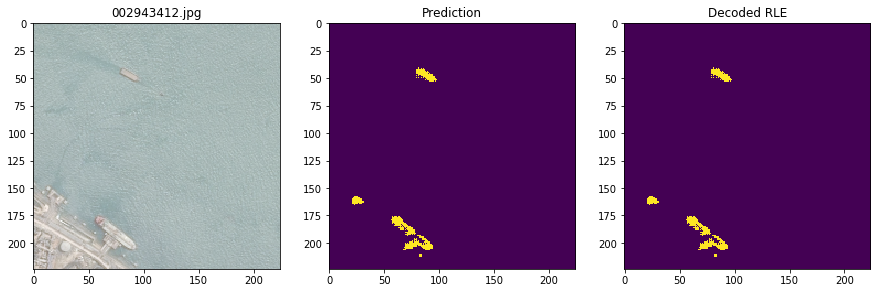

In [381]:
_, axs = plt.subplots(1, 3, figsize=(15, 15))
axs = axs.flatten()
axs[0].set_title(name)
axs[0].imshow(inp)
axs[1].set_title("Prediction")
axs[1].imshow(prediction)
axs[2].set_title("Decoded RLE")
axs[2].imshow(rle_decoded)